<a href="https://colab.research.google.com/github/rish4/Minor-Project/blob/main/VGG_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://deeplearningcourses.com/c/advanced-computer-vision
# https://www.udemy.com/advanced-computer-vision
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [2]:
# re-size all the images to this
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

In [3]:
# https://www.kaggle.com/moltean/fruits
train_path = '/content/drive/MyDrive/Cats and Dogs Dataset/training_set'
valid_path = '/content/drive/MyDrive/Cats and Dogs Dataset/test_set'

In [4]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [5]:
# useful for getting number of classes
folders = glob(train_path + '/*')

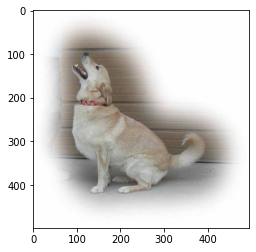

In [6]:
# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [7]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [9]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [11]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


In [12]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -104.37001 max: 151.061


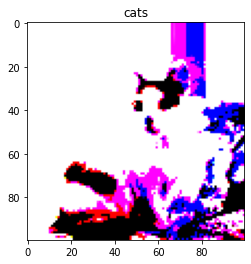

In [13]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [14]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [15]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
250/250 [==============================] - 2792s 11s/step - loss: 3.4979 - accuracy: 0.7986 - val_loss: 2.9635 - val_accuracy: 0.8231
Epoch 2/5
250/250 [==============================] - 908s 4s/step - loss: 2.7193 - accuracy: 0.8434 - val_loss: 2.7969 - val_accuracy: 0.8357
Epoch 3/5
250/250 [==============================] - 913s 4s/step - loss: 2.8468 - accuracy: 0.8434 - val_loss: 3.2653 - val_accuracy: 0.8306
Epoch 4/5
250/250 [==============================] - 909s 4s/step - loss: 2.6926 - accuracy: 0.8519 - val_loss: 3.0653 - val_accuracy: 0.8412
Epoch 5/5
250/250 [==============================] - 905s 4s/step - loss: 2.6202 - accuracy: 0.8580 - val_loss: 3.0836 - val_accuracy: 0.8432


In [16]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  import seaborn as sns
  f = sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')
  
  TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
  accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
  precision = TP / (TP+FP) # % positive out of all predicted positives
  recall =  TP / (TP+FN) # % positive out of all supposed to be positives
  specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
  f1 = 2*precision*recall / (precision + recall)
  stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
  print(stats_summary)

  return cm

Generating confusion matrix 8000
Found 8000 images belonging to 2 classes.
50
100
[Summary Statistics]
Accuracy = 85.92% | Precision = 84.20% | Recall = 88.45% | Specificity = 83.40% | F1 Score = 86.27%
[[3336  664]
 [ 462 3538]]


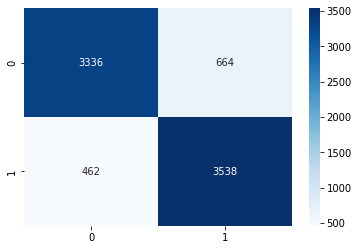

In [17]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)


Generating confusion matrix 2000
Found 2000 images belonging to 2 classes.
[Summary Statistics]
Accuracy = 85.15% | Precision = 83.19% | Recall = 88.10% | Specificity = 82.20% | F1 Score = 85.58%
[[822 178]
 [119 881]]


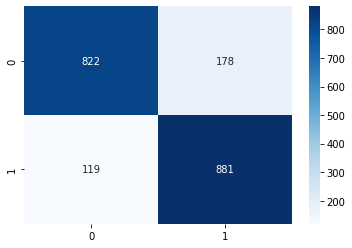

In [18]:
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

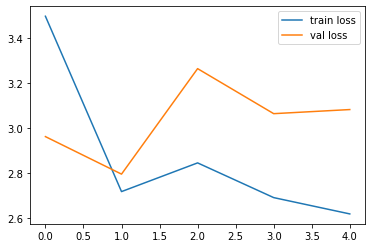

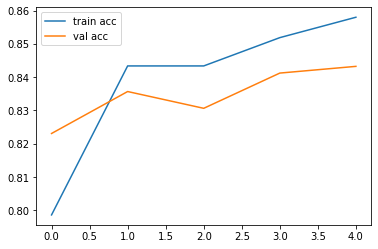

In [19]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

64


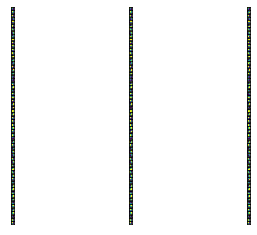

64


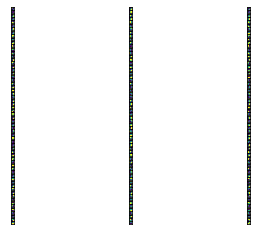

128


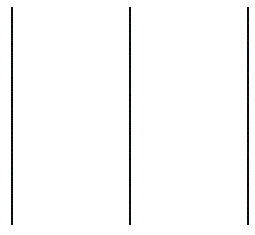

128


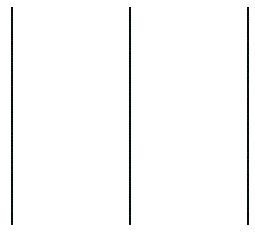

256


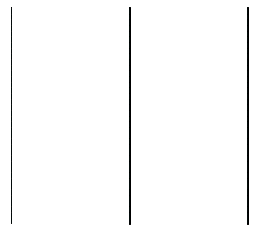

256


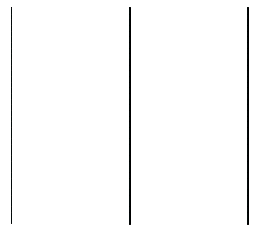

256


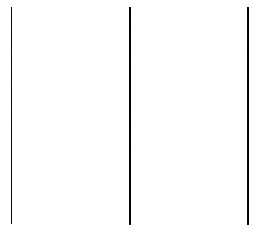

512


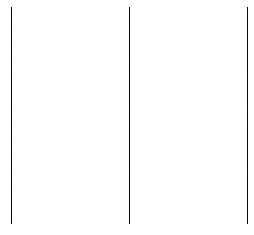

512


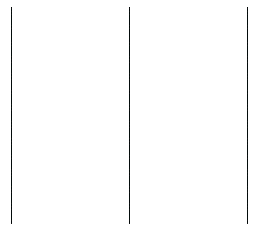

512


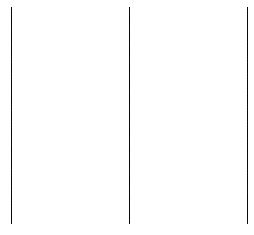

512


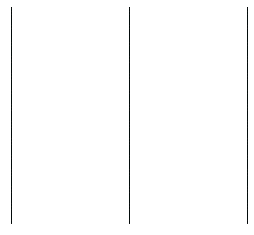

512


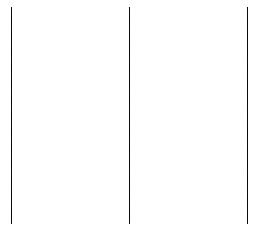

512


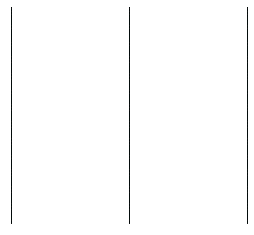

In [21]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        #print(layer.name, filters.shape)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

In [37]:
from keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf

(1, 100, 100, 64)
(1, 100, 100, 64)
(1, 50, 50, 64)
(1, 50, 50, 128)
(1, 50, 50, 128)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


(1, 25, 25, 128)
(1, 25, 25, 256)
(1, 25, 25, 256)
(1, 25, 25, 256)
(1, 12, 12, 256)
(1, 12, 12, 512)
(1, 12, 12, 512)
(1, 12, 12, 512)
(1, 6, 6, 512)
(1, 6, 6, 512)
(1, 6, 6, 512)
(1, 6, 6, 512)
(1, 3, 3, 512)
(1, 4608)
(1, 2)


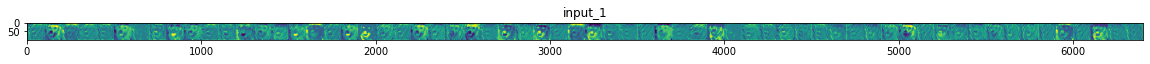

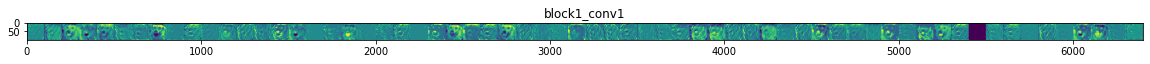

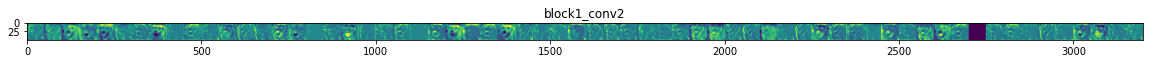

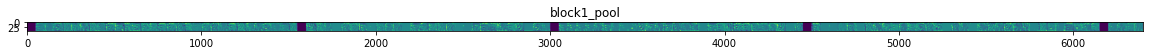

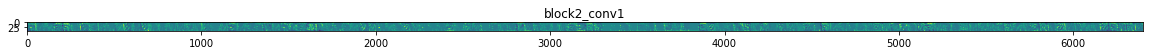

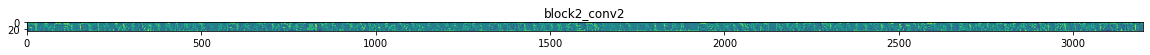

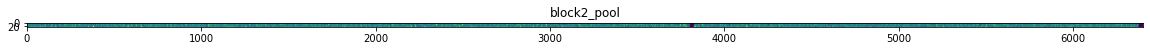

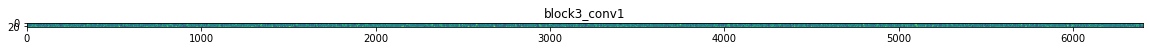

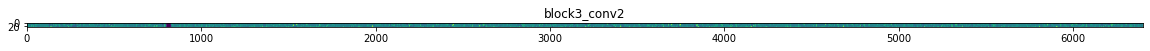

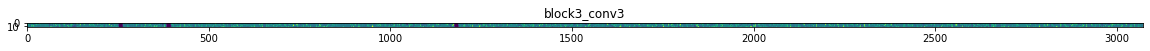

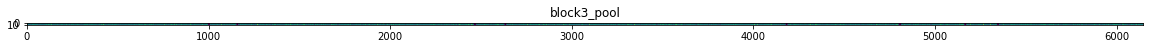

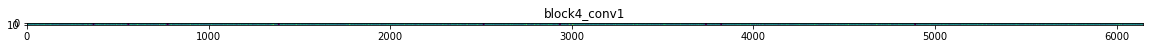

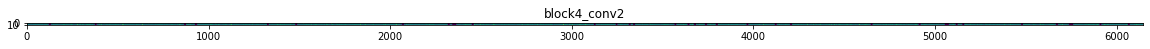

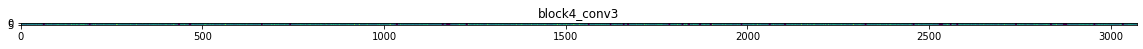

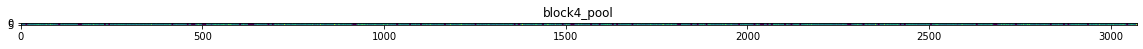

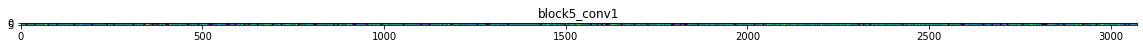

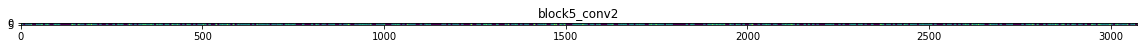

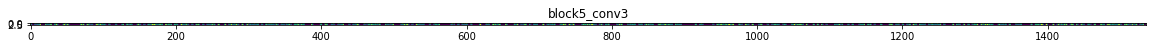

In [30]:
img_path='/content/drive/MyDrive/Cats and Dogs Dataset/test_set/dogs/dog.4014.jpg' #unhealthy
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(100, 100))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [57]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 block1_conv1 (None, 100, 100, 64)
2 block1_conv2 (None, 100, 100, 64)
4 block2_conv1 (None, 50, 50, 128)
5 block2_conv2 (None, 50, 50, 128)
7 block3_conv1 (None, 25, 25, 256)
8 block3_conv2 (None, 25, 25, 256)
9 block3_conv3 (None, 25, 25, 256)
11 block4_conv1 (None, 12, 12, 512)
12 block4_conv2 (None, 12, 12, 512)
13 block4_conv3 (None, 12, 12, 512)
15 block5_conv1 (None, 6, 6, 512)
16 block5_conv2 (None, 6, 6, 512)
17 block5_conv3 (None, 6, 6, 512)


In [64]:
from numpy import expand_dims
from matplotlib import pyplot

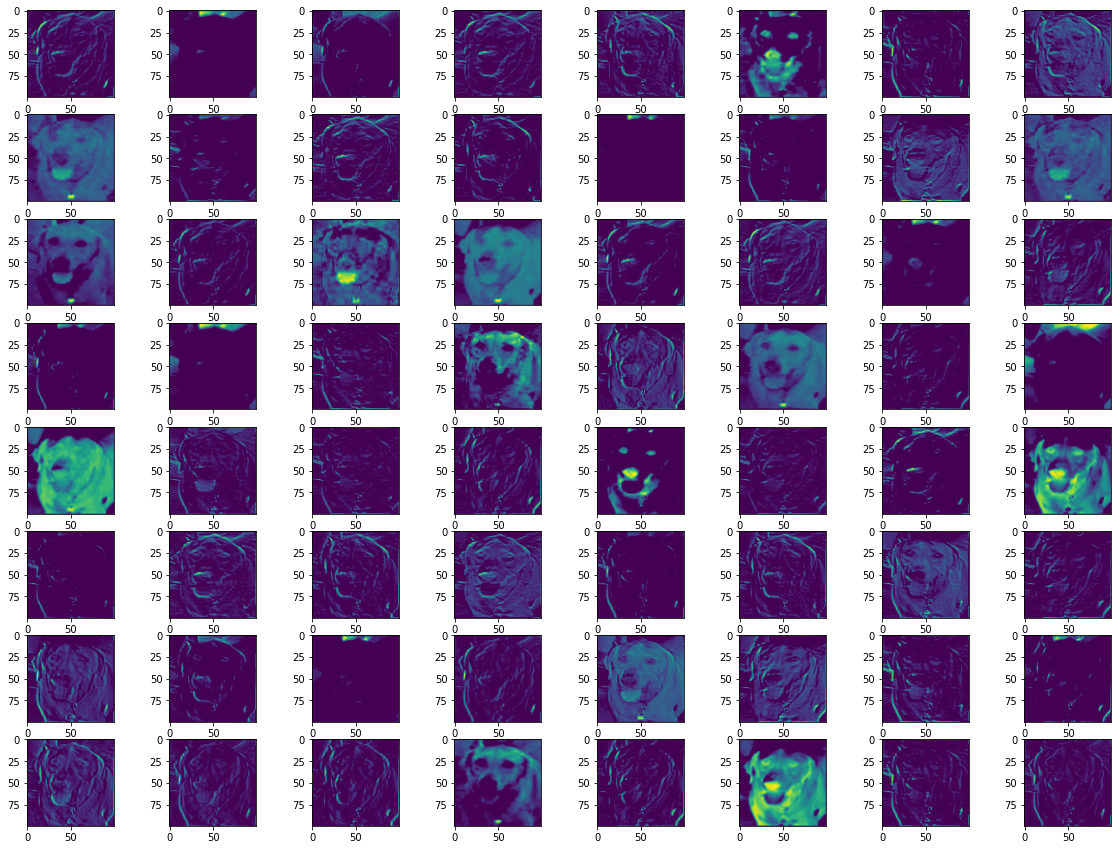

In [76]:
m = Model(inputs=model.inputs , outputs=model.layers[1].output)
image = load_img("/content/drive/MyDrive/Cats and Dogs Dataset/test_set/dogs/dog.4014.jpg" , target_size=(100,100))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)
image = preprocess_input(image)
#calculating features_map
features = model.predict(image)

fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(features[0,:,:,i-1] , cmap='viridis')
    
pyplot.show()

In [73]:
img_path='/content/drive/MyDrive/Cats and Dogs Dataset/test_set/dogs/dog.4143.jpg' #unhealthy
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(100, 100))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

(100, 100, 64)


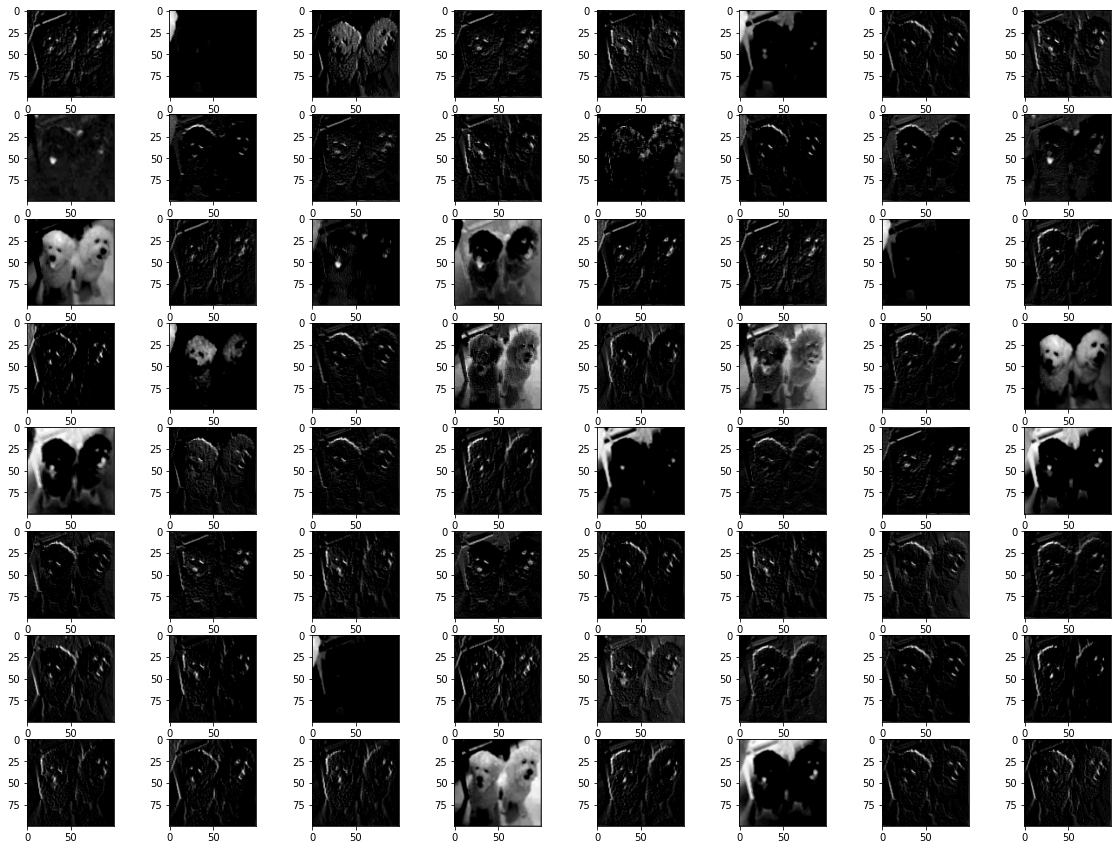

In [74]:
m = Model(inputs=model.inputs , outputs=model.layers[1].output)
image = load_img("/content/drive/MyDrive/Cats and Dogs Dataset/test_set/dogs/dog.4143.jpg" , target_size=(100,100))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)
image = preprocess_input(image)
#calculating features_map
features = model.predict(image)

fig = pyplot.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    pyplot.subplot(8,8,i)
    pyplot.imshow(features[0,:,:,i-1] , cmap='gray')
    
pyplot.show()

In [ ]:
img_path='/content/drive/MyDrive/Cats and Dogs Dataset/test_set/cats/cat.4023.jpg' #unhealthy
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in cnn.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = cnn.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(64, 64))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in cnn.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [ ]:
img_path='/content/drive/MyDrive/Cats and Dogs Dataset/test_set/cats/cat.4060.jpg' #unhealthy
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in cnn.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = cnn.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(64, 64))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in cnn.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )